# Tourism recommendation system

A toy example.

In [172]:
%%capture
%load_ext autoreload
%autoreload 2

In [173]:
from src.repository import DatabaseClient, to_table, \
    CityRepository, CountryRepository, RegionRepository, \
    UserRepository, AirlineRepository, HotelRepository, \
    City, Country, Region, User, Airline, Hotel

from src.entity_loader import EntityLoader, CityMapper, RegionMapper, \
   UserMapper, CountryMapper, AirlineMapper, HotelMapper

from time import sleep
import os 
from IPython.display import Image

In [174]:
def now_str():
    import datetime
    datetime = datetime.datetime.now()
    return "{:%Y-%m-%dT%H:%M:%S}".format(datetime)

## Setup database

#### Download neo4j

In [175]:
if os.path.isfile('./nj'): 
    # download 3.5.8 or neo4j-enterprise-4.0.0-alpha09mr02-unix
    !curl https://neo4j.com/artifact.php?name=neo4j-community-3.5.8-unix.tar.gz -o neo4j.tar.gz
    # decompress and rename
    !tar -xf neo4j.tar.gz  # or --strip-components=1
    !mv neo4j-community-3.5.8 nj
    # disable password, and start server
    !sed -i '/#dbms.security.auth_enabled/s/^#//g' nj/conf/neo4j.conf
    print("Neo4j server downloaded!")
else:
    print("Neo4j server already downloaded!")

Neo4j server already downloaded!


#### Start/Stop neo4j database server

In [176]:
!nj/bin/neo4j restart

In [177]:
sleep(5)

In [178]:
# !nj/bin/neo4j stop

## Prepare data access

####  1. Create database client

In [179]:
USERNAME = PASSWORD = "neo4j"
URL = "bolt://localhost:7687"

client = DatabaseClient(URL, USERNAME, PASSWORD)

### 2. Create repositories

In [180]:
city_repository = CityRepository(client)

country_repository = CountryRepository(client)

region_repository = RegionRepository(client)

user_repository = UserRepository(client)

airline_repository = AirlineRepository(client)

hotel_repository = HotelRepository(client)

## Prepare database

#### 1. Remove all nodes

In [181]:
client.run("MATCH (n) DETACH DELETE n")

#### 2. Load cities

In [182]:
cities = list(EntityLoader.load_map('database/cities.json', CityMapper()))

print(f'Cities: {len(cities)}')

Cities: 6


In [183]:
city_repository.upsert(cities)

Cities

In [184]:
for e in cities: print(e.code, e.name)

BUE Buenos Aires
COR Cordoba Capital
SLA Salta capital
BCN Barcelona
RIO Rio do Janeiro
MIA Miami


#### 3. Load countries

In [185]:
countries = list(EntityLoader.load_map('database/countries.json', CountryMapper()))

print(f'Countries: {len(countries)}')

Countries: 4


In [186]:
country_repository.upsert(countries)

Countries

In [187]:
for e in countries: print(e.code, e.name)

ARG Argentina
ESP Spain
BRA Brazil
USA United States


#### 4. Load global regions

In [188]:
regions = list(EntityLoader.load_map('database/regions.json', RegionMapper()))

print(f'Global Regions: {len(regions)}')

Global Regions: 7


In [189]:
region_repository.upsert(regions)

Regions

In [190]:
for e in regions: print(e.code, e.name)

AF Africa
CB El caribe
CA Centro America
EU Europa
NA Norte America
OC Oceania
SA Sud America


#### 5. Load users

In [191]:
users = list(EntityLoader.load_map('database/users.json', UserMapper()))

print(f'Users: {len(users)} / {users[0]}')

Users: 7 / User(id=1, email='adrian.marino@almundo.com', realm='ALMUNDO-ALMUNDO-EMPLOYEE')


In [192]:
user_repository.upsert(users)

Users

In [193]:
for e in users: print(e.email)

adrian.marino@almundo.com
juanmanuel.bouvier@almundo.com
sofia.massobrio@almundo.com
facundo.etchanchu@almundo.com
kevin.klaus@almundo.com
gonzalo.prieto@almundo.com
diego.saez@almundo.com


In [194]:
adrian = "adrian.marino@almundo.com"
juanma = "juanmanuel.bouvier@almundo.com"
sofi = "sofia.massobrio@almundo.com"
facu = "facundo.etchanchu@almundo.com"
kevo = "kevin.klaus@almundo.com"
gonza = "gonzalo.prieto@almundo.com"
diego = "diego.saez@almundo.com"

#### 6. Load airlines

In [195]:
airlines = list(EntityLoader.load_map('database/airlines.json', AirlineMapper()))

print(f'Airlines: {len(airlines)}')

Airlines: 9


In [196]:
airline_repository.upsert(airlines)

In [197]:
for e in airlines: print(e.code, e.name)

AA American Airlines
AR Aerolines Argentinas
EK Emirates
LA LATAM
LH Lufthansa
AF Air France
AZ Alitalia
AM Aeromexico
QA Qantas Airways


#### 7. Load Hotels

In [198]:
hotels = list(EntityLoader.load_map('database/hotels.json', HotelMapper()))

print(f'Hotels: {len(hotels)}')

Hotels: 12


In [199]:
hotel_repository.upsert(hotels)

Hotels

In [200]:
for e in hotels: print(e.id, e.name)

1 Madagascar Palace
2 See Palace Resort
3 Beach Palace Resort
4 Barcelona Hotel
5 Malaga Hotel Resort
6 Hotel Imperial
7 Hotel procincial
8 Posada Santana
9 El rincon del descanso
10 Rio See Resort
11 Pipa Hotel
12 Hakuna Matata Hotel Bar


#### 8. Add citiy belong to country relation

In [201]:
def city_belong_to_country(relation):
    client.run("""
        MATCH
            (city: City {code: '%s'}),
            (country: Country {code: '%s'})
        WITH
            city,
            country
        MERGE
            (city)-[:BELONG_TO]->(country)
    """ %(relation['city'],relation['country'])
)

In [202]:
city_country_relations = list(EntityLoader.load('database/city-country.json'))
print(f'Relations: {len(city_country_relations)}')

Relations: 6


In [203]:
for r in city_country_relations: city_belong_to_country(r)

In [204]:
for e in city_country_relations: print(e['city'], e['country'])

BUE ARG
COR ARG
SLA ARG
BCN ESP
RIO BRA
MIA USA


#### 9. Add country belong to region relation

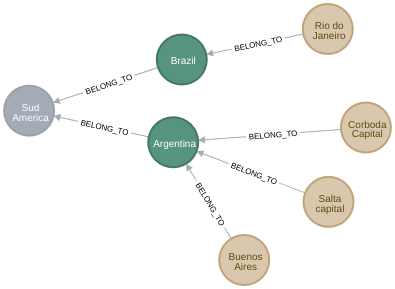

In [205]:
Image(filename='images/region-country-city.png') 

In [206]:
def country_belong_to_region(relation):
    client.run("""
        MATCH
            (country: Country {code: '%s'}),
            (region: Region {code: '%s'})
        WITH
            country,
            region
        MERGE
            (country)-[:BELONG_TO]->(region)
    """ %(relation['country'],relation['region'])
)

In [207]:
country_region_relations = list(EntityLoader.load('database/country-region.json'))
print(f'Relations: {len(country_region_relations)}')

Relations: 4


In [208]:
for r in country_region_relations: country_belong_to_region(r)

In [209]:
for e in country_region_relations: print(e['country'], e['region'])

ARG SA
BRA SA
ESP EU
USA NA


#### 10. Add hotel located in city relation

In [210]:
def hotel_belong_to_city(relation):
    client.run("""
        MATCH
            (hotel: Hotel {_id: '%s'}),
            (city: City {code: '%s'})
        WITH
            hotel,
            city
        MERGE
            (hotel)-[:LOCATED_IN]->(city)
    """ %(relation['hotel_id'],relation['city_code'])
)

In [211]:
hotel_city_relations = list(EntityLoader.load('database/hotel-city.json'))
print(f'Relations: {len(hotel_city_relations)}')

Relations: 12


In [212]:
for r in hotel_city_relations: hotel_belong_to_city(r)

In [213]:
for e in hotel_city_relations: print(e['hotel_id'], e['city_code'])

1 MIA
2 MIA
3 MIA
4 BCN
5 BCN
6 BCN
7 SLA
8 SLA
9 SLA
10 RIO
11 RIO
12 RIO


In [214]:
hotel_mia = [1, 2, 3]
hotel_bcn = [4, 5, 6]
hotel_sla = [7, 8, 9]
hotel_rio = [10, 11, 12]

#### 10. Create products search events

In [215]:
sleep(10)

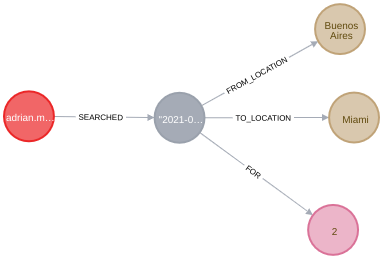

In [216]:
Image(filename='images/flight-search.png') 

In [217]:
def flight_search_event(
    email,
    from_city,
    to_city,
    from_datetime="2021-01-01T20:00:0",
    to_datetime="2021-01-15T20:00:0",
    adults=2,
    children=2,
    infants=1,
    search_datetime=now_str(),
    times=1
):
    for search_number in range(times):
        client.run("""
            MATCH
                (fromCity: City {code: '%s'}), 
                (toCity: City {code: '%s'}),
                (user: User {email: '%s'})
            WITH
                fromCity, toCity, user
            CREATE
                (search:FlightSearchEvent {
                    product_type: 'FLIGHT',
                    from: datetime('%s'),
                    to: datetime('%s')
                }),

                (search)-[:FROM_LOCATION]->(fromCity), 
                (search)-[:TO_LOCATION]->(toCity),

                (search)-[:FOR]->(:Persons{adults:%s, children: %s, infants: %s}),

                (user)-[:SEARCHED {datetime: datetime("%s") - duration('P%sD')}]->(search)

            """ % (from_city, to_city, email, from_datetime, to_datetime, adults, children, infants, search_datetime, search_number)
        )

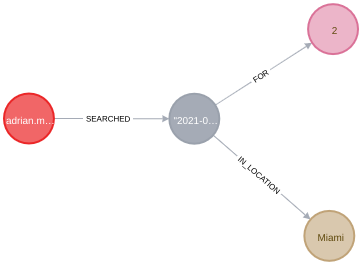

In [218]:
Image(filename='images/hotel-search.png') 

In [219]:
def hotel_search_event(
    email,
    city,
    from_datetime="2021-01-01T20:00:0",
    to_datetime="2021-01-15T20:00:0",
    adults=2,
    children=2,
    infants=1,
    search_datetime=now_str(),
    times=1
):
    for search_number in range(times):
        client.run("""
            MATCH
                (city: City {code: '%s'}),
                (user: User {email: '%s'})
            WITH
                city, user
            CREATE
                (search:HotelSearchEvent {
                    product_type: 'HOTEL',
                    from: datetime('%s'),
                    to: datetime('%s')
                }),
                (search)-[:IN_LOCATION]->(city), 
                (search)-[:FOR]->(:Persons{adults: %s, children: %s, infants: %s}),
                (user)-[:SEARCHED {datetime: datetime("%s") - duration('P%sD')}]->(search)

            """ % (city, email, from_datetime, to_datetime, adults, children, infants, search_datetime, search_number)
        )

**WAIT!!!: Wait for it to finish prevous nodes and relations creation**

Adrian searches: 

In [220]:
flight_search_event(email=adrian, from_city="BUE", to_city="MIA", times=3)
hotel_search_event(email=adrian, city="MIA", times=8)

flight_search_event(email=adrian, from_city="BUE", to_city="SLA", times=10)
hotel_search_event(email=adrian, city="SLA", times= 10)

flight_search_event(email=adrian, from_city="BUE", to_city="BCN", times= 5)
hotel_search_event(email=adrian, city="BCN", times=10)

Juan manuel searches:

In [221]:
flight_search_event(email=juanma, from_city="COR", to_city="SLA", times=10)

Sofia searches:

In [222]:
flight_search_event(email=sofi, from_city="BUE", to_city="RIO", times=15)
flight_search_event(email=sofi, from_city="RIO", to_city="BCN", times=10)
flight_search_event(email=sofi, from_city="BUE", to_city="MIA", times=8)
flight_search_event(email=sofi, from_city="COR", to_city="SLA", times=3)
flight_search_event(email=sofi, from_city="SLA", to_city="COR", times=5)

Kevin searches:

In [223]:
flight_search_event(email=kevo, from_city="COR", to_city="SLA", times=4)
flight_search_event(email=kevo, from_city="BUE", to_city="MIA", times=5)

hotel_search_event(email=kevo, city="MIA", times=5)
hotel_search_event(email=kevo, city="COR", times=5)
hotel_search_event(email=kevo, city="SLA", times=5)

Facundo searches:

In [224]:
hotel_search_event(email=facu, city="BCN", times=5)
hotel_search_event(email=facu, city="MIA", times=5)
hotel_search_event(email=facu, city="RIO", times=5)

flight_search_event(email=facu, from_city="BUE", to_city="RIO", times=5)
flight_search_event(email=facu, from_city="BUE", to_city="SLA", times=10)
flight_search_event(email=facu, from_city="BUE", to_city="BCN", times=5)

Diego searches:

In [225]:
hotel_search_event(email=diego, city="BCN", times=5)
hotel_search_event(email=diego, city="MIA", times=5)
hotel_search_event(email=diego, city="RIO", times=5)

flight_search_event(email=diego, from_city="BUE", to_city="RIO", times=5)
flight_search_event(email=diego, from_city="BUE", to_city="SLA", times=5)
flight_search_event(email=diego, from_city="BUE", to_city="BCN", times=5)

#### 9. Add product purchases

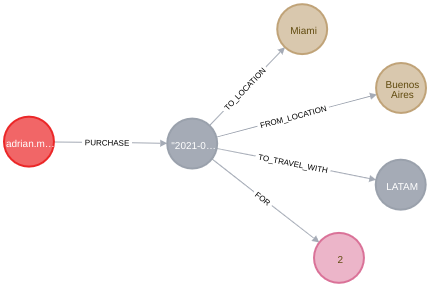

In [226]:
Image(filename='images/flight-reservation.png') 

In [227]:
def flight_purchease(
    email,
    from_city,
    to_city,
    airline,
    from_datetime="2021-01-01T20:00:0",
    to_datetime="2021-01-15T20:00:0",
    adults=2,
    children=2,
    infants=1,
    datetime=now_str(),
    times=1
):
    for number in range(times):
        client.run("""
            MATCH 
                (fromCity: City {code: '%s'}),
                (toCity: City {code: '%s'}),
                (user: User{email: '%s'}),
                (airline: Airline {code: '%s'})
            WITH
                fromCity, toCity, user, airline

            CREATE
                (reservation: FlightReservation {
                    product_type: 'flight',
                    from: datetime('%s'),
                    to: datetime('%s')
                }),

                (reservation)-[:TO_TRAVEL_WITH]->(airline),

                (reservation)-[:FROM_LOCATION]->(fromCity),
                (reservation)-[:TO_LOCATION]->(toCity),

                (reservation)-[:FOR]->(:Persons{adults: %s, children: %s, infants: %s}),

                (user)-[:PURCHASE {datetime: datetime('%s') - duration('P%sD')}]->(reservation)

            """ % (from_city, to_city, email, airline, from_datetime, to_datetime, adults, children, infants, datetime, number * 3)
        )

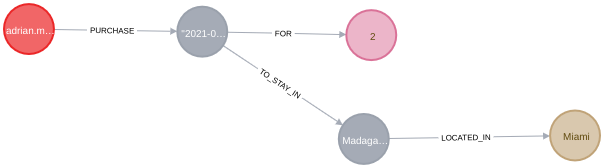

In [228]:
Image(filename='images/hotel-reservation.png') 

In [229]:
def hotel_purchease(
    email,
    hotel_id,
    from_datetime="2021-01-01T20:00:0",
    to_datetime="2021-01-15T20:00:0",
    adults=2,
    children=2,
    infants=1,
    datetime=now_str(),
    times=1
):
    for number in range(times):
        client.run("""
            MATCH 
                (hotel: Hotel {_id: '%s'}),
                (user: User{email: '%s'})
            WITH
                hotel, user
            CREATE
                (reservation: HotelReservation {
                    product_type: 'hotel',
                    from: datetime('%s'),
                    to: datetime('%s')
                }),

                (reservation)-[:TO_STAY_IN]->(hotel),

                (reservation)-[:FOR]->(:Persons{adults: %s, children: %s, infants: %s}),

                (user)-[:PURCHASE {datetime: datetime('%s') - duration('P%sD')}]->(reservation)
                
            """ % (hotel_id, email, from_datetime, to_datetime, adults, children, infants, datetime, number * 5)
        )

Adrian purchases:

In [230]:
flight_purchease(email=adrian, from_city="BUE", to_city="MIA", airline="LA")
hotel_purchease(email=adrian, hotel_id = hotel_mia[0])

flight_purchease(email=adrian, from_city="BUE", to_city="RIO", airline="EK")
hotel_purchease(email=adrian, hotel_id = hotel_rio[0])

flight_purchease(email=adrian, from_city="COR", to_city="SLA", airline="AR")
hotel_purchease(email=adrian, hotel_id = hotel_sla[0])

Juan manuel purchases:

In [231]:
flight_purchease(email=juanma, from_city="COR", to_city="SLA", airline="LA")
hotel_purchease(email=juanma, hotel_id = hotel_rio[1])

flight_purchease(email=juanma, from_city="SLA", to_city="RIO", airline="LA")
hotel_purchease(email=juanma, hotel_id = hotel_rio[2])

flight_purchease(email=juanma, from_city="SLA", to_city="RIO", airline="LA")
hotel_purchease(email=juanma, hotel_id = hotel_rio[0])

Sofia purchases:

In [232]:
flight_purchease(email=sofi, from_city="BUE", to_city="RIO", airline="AA")
hotel_purchease(email=sofi, hotel_id = hotel_rio[0])

flight_purchease(email=sofi, from_city="BUE", to_city="SLA", airline="LA")
hotel_purchease(email=sofi, hotel_id = hotel_sla[1])

Kevin purchases:

In [233]:
hotel_purchease(email=kevo, hotel_id = hotel_bcn[0])

flight_purchease(email=kevo, from_city="COR", to_city="SLA", airline="LA")
hotel_purchease(email=kevo, hotel_id = hotel_sla[1])

Facundo purchases:

In [234]:
hotel_purchease(email=facu, hotel_id = hotel_mia[2])
hotel_purchease(email=facu, hotel_id = hotel_bcn[0])
hotel_purchease(email=facu, hotel_id = hotel_rio[2])
hotel_purchease(email=facu, hotel_id = hotel_sla[1])

Gonza purchases:

In [235]:
flight_purchease(email=gonza, from_city="BUE", to_city="MIA", airline="AA")
hotel_purchease(email=gonza, hotel_id = hotel_mia[1])

flight_purchease(email=gonza, from_city="BUE", to_city="RIO", airline="AA")
hotel_purchease(email=gonza, hotel_id = hotel_rio[2])

flight_purchease(email=gonza, from_city="BUE", to_city="BCN", airline="EK")
hotel_purchease(email=gonza, hotel_id = hotel_sla[1])

## Query trends and recomendations

In [236]:
sleep(10)

#### 1. Give me top 5 more purchased flighs by destination and airline in the last 60 days

In [237]:
QUERY1 = """
MATCH   (:User)-[p:PURCHASE]->
        (r)-[:TO_LOCATION]->
        (c:City),
        (r)-[:TO_TRAVEL_WITH]->(a:Airline)
WHERE    
    p.datetime >= (datetime() - duration('P60D'))
RETURN
    COUNT(*) as score,
    c.name as destination,
    a.name as airline
ORDER BY
    score DESC,
    destination ASC,
    airline ASC
LIMIT 5
"""
columns=['score', 'destination', 'airline' ]

client.query(lambda tx: to_table(tx.run(QUERY1), columns))

,SCORE,DESTINATION,AIRLINE
0,3,Salta capital,LATAM
1,2,Rio do Janeiro,American Airlines
2,2,Rio do Janeiro,LATAM
3,1,Barcelona,Emirates
4,1,Miami,American Airlines


#### 2. Give me top 5 more purchased hotels by destination in the last 60 days

In [238]:
QUERY2 = """
MATCH   (:User)-[p:PURCHASE]->
		(:HotelReservation)-[:TO_STAY_IN]->
        (h:Hotel)-[:LOCATED_IN]->
        (c:City)
WHERE    
    p.datetime >= (datetime() - duration('P60D'))
RETURN
    COUNT(*) as score,
    c.name as destination,
    h.name as hotel
ORDER BY
    score DESC,
    destination ASC
LIMIT 5

"""
columns=['score', 'destination', 'hotel']

client.query(lambda tx: to_table(tx.run(QUERY2), columns))

,SCORE,DESTINATION,HOTEL
0,4,Salta capital,Posada Santana
1,3,Rio do Janeiro,Hakuna Matata Hotel Bar
2,3,Rio do Janeiro,Rio See Resort
3,2,Barcelona,Barcelona Hotel
4,1,Miami,Madagascar Palace


#### 3. Give me top 5 more searched destination for flights in the last 60 days

In [239]:
QUERY3 = """
MATCH   (:User)-[s:SEARCHED]->
        (e:FlightSearchEvent)-[:TO_LOCATION]->
        (c:City)
WHERE    
    s.datetime >= (datetime() - duration('P60D'))
RETURN
    COUNT(*) as score,
    c.name as destination
ORDER BY
    score DESC,
    destination ASC
LIMIT 5

"""
columns=['score', 'destination']

client.query(lambda tx: to_table(tx.run(QUERY3), columns))

,SCORE,DESTINATION
0,42,Salta capital
1,25,Barcelona
2,25,Rio do Janeiro
3,16,Miami
4,5,Cordoba Capital


#### 4. Give me top 5 more searched destination for hotels in the last 60 days

In [240]:
QUERY4 = """
MATCH   (:User)-[s:SEARCHED]->
        (e:HotelSearchEvent)-[:IN_LOCATION]->
        (c:City)
WHERE    
    s.datetime >= (datetime() - duration('P60D'))
RETURN
    COUNT(*) as score,
    c.name as destination
ORDER BY
    score DESC,
    destination ASC
LIMIT 5
"""
columns=['score', 'destination']

client.query(lambda tx: to_table(tx.run(QUERY4), columns))

,SCORE,DESTINATION
0,23,Miami
1,20,Barcelona
2,15,Salta capital
3,10,Rio do Janeiro
4,5,Cordoba Capital


#### 5. Recommend hotels to users who bought flight to a given destination

In [241]:
def hotel_recomendations_by_flight_destination_for_purchaser_user(email, time_window):
    query = """
        MATCH
          (u:User {email: '%s'})

            -[up:PURCHASE]->(:FlightReservation)
            -[:TO_LOCATION]->

          (c:City)

              <-[:LOCATED_IN]-(h:Hotel)
              <-[:TO_STAY_IN]-(hr:HotelReservation)
              <-[op:PURCHASE]-

          (ou:User)
                WHERE
                    ou <> u
                    AND up.datetime >= (datetime() - duration('P%sD')) 
                    AND op.datetime >= (datetime() - duration('P%sD'))
                WITH
                    c.name as purchased_destination,
                    h.name as hotels_to_recommend,
                    REDUCE (sc=0, c in COLLECT(h) | sc+1 ) AS score
                RETURN
                    purchased_destination,
                    hotels_to_recommend,
                    score
                ORDER BY
                    score DESC
                LIMIT 5
    """ % (email, time_window, time_window)

    return client.query(lambda tx: to_table(tx.run(query), columns=['purchased_destination', 'hotels_to_recommend', 'score']))


hotel_recomendations_by_flight_destination_for_purchaser_user(
    email="adrian.marino@almundo.com",
    time_window = 60  # In days
)

,PURCHASED_DESTINATION,HOTELS_TO_RECOMMEND,SCORE
0,Salta capital,Posada Santana,4
1,Rio do Janeiro,Hakuna Matata Hotel Bar,3
2,Rio do Janeiro,Rio See Resort,2
3,Miami,See Palace Resort,1
4,Rio do Janeiro,Pipa Hotel,1


#### 6. Recommend flights airlines to users who bought hotels for a given destination

In [242]:
def airline_recomendations_by_hotel_destination_for_purchaser_user(email, time_window):
    query = """
        MATCH
          (u:User {email: '%s'})
            -[up:PURCHASE]->(:HotelReservation)
            -[:TO_STAY_IN]->(:Hotel)
            -[:LOCATED_IN]->

          (c:City)

              <-[:TO_LOCATION]-(fr:FlightReservation)
              <-[op:PURCHASE]-
          (ou:User),
            (fr)-[:TO_TRAVEL_WITH]->(a:Airline)
                WHERE
                    ou <> u
                    AND up.datetime >= (datetime() - duration('P%sD')) 
                    AND op.datetime >= (datetime() - duration('P%sD'))
                WITH
                    c.name as puchased_destination,
                    a.name as airlines_to_recommend,
                    REDUCE (sc=0, c in COLLECT(a) | sc+1 ) AS score
                RETURN
                    puchased_destination,
                    airlines_to_recommend,
                    score
                ORDER BY
                    score DESC
                LIMIT 5
    """ % (email, time_window, time_window)

    return client.query(lambda tx: to_table(tx.run(query), columns=['puchased_destination', 'airlines_to_recommend', 'score']))


airline_recomendations_by_hotel_destination_for_purchaser_user(
    email="adrian.marino@almundo.com",
    time_window = 60  # In days
)

,PUCHASED_DESTINATION,AIRLINES_TO_RECOMMEND,SCORE
0,Salta capital,LATAM,3
1,Rio do Janeiro,American Airlines,2
2,Rio do Janeiro,LATAM,2
3,Miami,American Airlines,1
